<a href="https://colab.research.google.com/github/sashafromlibertalia/deep-learning-labs/blob/main/RL_2025_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [29]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [3]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [4]:
import gym
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output

def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [31]:
def choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    if done:
      Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    else:
      Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2, :]) - Q[state, action])

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [6]:
np.random.seed(random_seed)

In [7]:
from tqdm import tqdm

# Inititalization
wins_arr = []
min_game = 0
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        # Проверяем последние 5 игр
        if (len(wins_arr) >= 5 and wins_arr[-5:] == [1, 1, 1, 1, 1] and min_game == 0):
            min_game = game

        t += 1

        action = choose_action(state)

        state2, reward, done, info = env.step(action)

        if t == max_steps:
          done = True

        learn(state, state2, reward, action, done)

        state = state2

        # Если эпизод завершился победой
        if done and reward == 1:
          wins_arr.append(1)
          break

        # Если эпизод завершился не победой
        if done:
          wins_arr.append(0)
          break

100%|██████████| 10000/10000 [00:14<00:00, 696.05it/s]


Вывод ответов при заданных параметрах

In [8]:
assert np.sum(wins_arr) == 7914
assert min_game == 885

Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [9]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

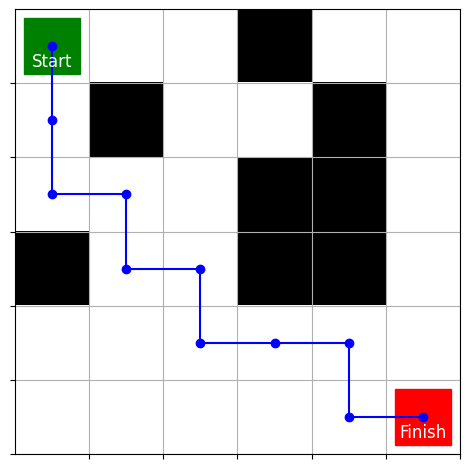

In [10]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



In [32]:
def learn(state, state2, reward, action, action2, done):
    if done:
      Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    else:
      Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2, action2]) - Q[state, action])

In [36]:
from tqdm import tqdm
np.random.seed(random_seed)
wins_arr = []
min_game = 0
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))

#Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    action = choose_action(state) #Выбор действия в самом начале каждой игры
    while t < max_steps:
        # Проверяем последние 5 игр
        if (len(wins_arr) >= 5 and wins_arr[-5:] == [1, 1, 1, 1, 1] and min_game == 0):
            min_game = game

        t += 1

        state2, reward, done, info = env.step(action)

        action2 = choose_action(state2) #выбор действия как для следующего шага игры, так и для обновления ценности совершенного действия

        if t == max_steps:
          done = True

        learn(state, state2, reward, action, action2, done) # action2 также передается в функцию обучения

        state = state2
        action = action2

        # Если эпизод завершился победой
        if done and reward == 1:
            wins_arr.append(1)
            break

        # Если эпизод завершился не победой
        if done:
            wins_arr.append(0)
            break

100%|██████████| 40000/40000 [00:50<00:00, 795.62it/s]


In [38]:
assert np.sum(wins_arr) == 32328
assert min_game == 894

В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

# Cравнение гиперпараметров

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
params_config = {
    'gammas': [0.1, 1.2],
    'learning_rates': [0.001, 0.1],
    'epsilons': [0.001, 0.1],
}

In [41]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator

class RLAgentEstimator(BaseEstimator):
    def __init__(self, gamma=0.8, learning_rate=0.1, eps=0.1):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.eps = eps

    def choose_action(self, state):
      action=0
      if np.random.uniform(0, 1) < self.eps:
          action = np.random.randint(0, env.action_space.n)
      else:
          action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
      return action

    def learn(self, state, state2, reward, action, done):
      if done:
        self.Q[state, action] = Q[state, action] + self.learning_rate * (reward - Q[state, action])
      else:
        self.Q[state, action] = Q[state, action] + self.learning_rate * (reward + self.gamma * np.max(Q[state2, :]) - Q[state, action])

    def evaluate_game(self):
      wins_arr = []
      min_game = 0
      total_games = 10000
      max_steps = 100

      self.Q = np.zeros((env.observation_space.n, env.action_space.n))

      cumulative_rewards = np.zeros((total_games, max_steps))
      steps_per_game = np.zeros(total_games)

      for game in tqdm(range(total_games)):
        state = env.reset()
        t = 0

        while t < max_steps:
            # Проверяем последние 5 игр
            if (len(wins_arr) >= 5 and wins_arr[-5:] == [1, 1, 1, 1, 1] and min_game == 0):
                min_game = game

            t += 1
            action = self.choose_action(state)
            state2, reward, done, info = env.step(action)

            if (t == 1):
              cumulative_rewards[game, t - 1] = reward
            else:
              cumulative_rewards[game, t - 1] = cumulative_rewards[game, t - 2] + reward

            if t == max_steps:
              done = True

            self.learn(state, state2, reward, action, done)

            state = state2

            if done:
              # Если эпизод завершился победой
              if reward == 1:
                wins_arr.append(1)
              # Если эпизод завершился не победой
              else:
                wins_arr.append(0)
              break

        steps_per_game[game] = t

      mean_cum_rewards = np.mean(cumulative_rewards, axis=0)
      return mean_cum_rewards, steps_per_game

    def score(self):
        return self.evaluate_game()

In [42]:
%%time
results = []

for gamma in params_config['gammas']:
  for lr in params_config['learning_rates']:
    for eps in params_config['epsilons']:
      agent = RLAgentEstimator(gamma=gamma, learning_rate=lr, eps=eps)
      mean_cum_rewards, steps_per_game = agent.score()

      results.append({
          'mean_rewards': mean_cum_rewards,
          'steps_per_game': steps_per_game,
          'gamma': gamma,
          'lr': lr,
          'eps': eps
      })

results = pd.DataFrame(results)

100%|██████████| 10000/10000 [00:07<00:00, 1332.35it/s]

CPU times: user 1min 1s, sys: 4.47 s, total: 1min 6s
Wall time: 1min 4s


## Средняя награда

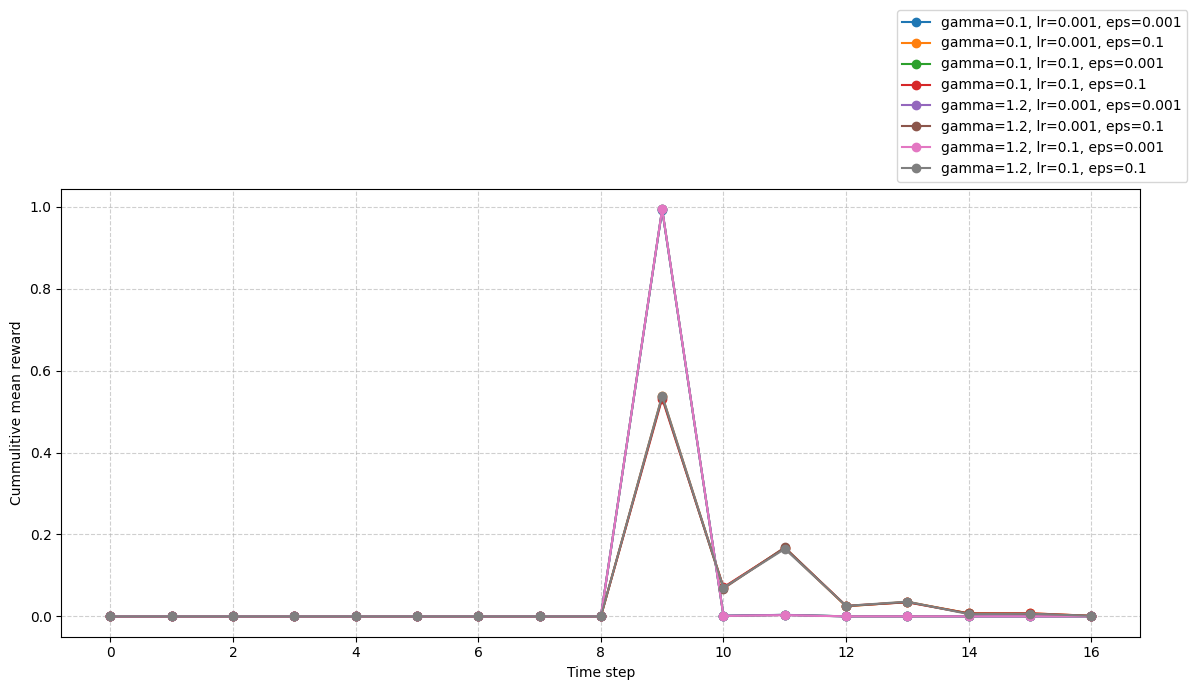

In [43]:
plt.figure(figsize=(12, 7))

for id, row in results.iterrows():
    gamma = row['gamma']
    lr = row['lr']
    eps = row['eps']

    legend_label = f'gamma={round(gamma, 3)}, lr={round(lr, 3)}, eps={round(eps, 3)}'
    plt.plot(row['mean_rewards'][:17], marker='o', label=legend_label, linewidth=1.5)

plt.xlabel('Time step')
plt.ylabel('Cummulitive mean reward')
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

## Число шагов в игре

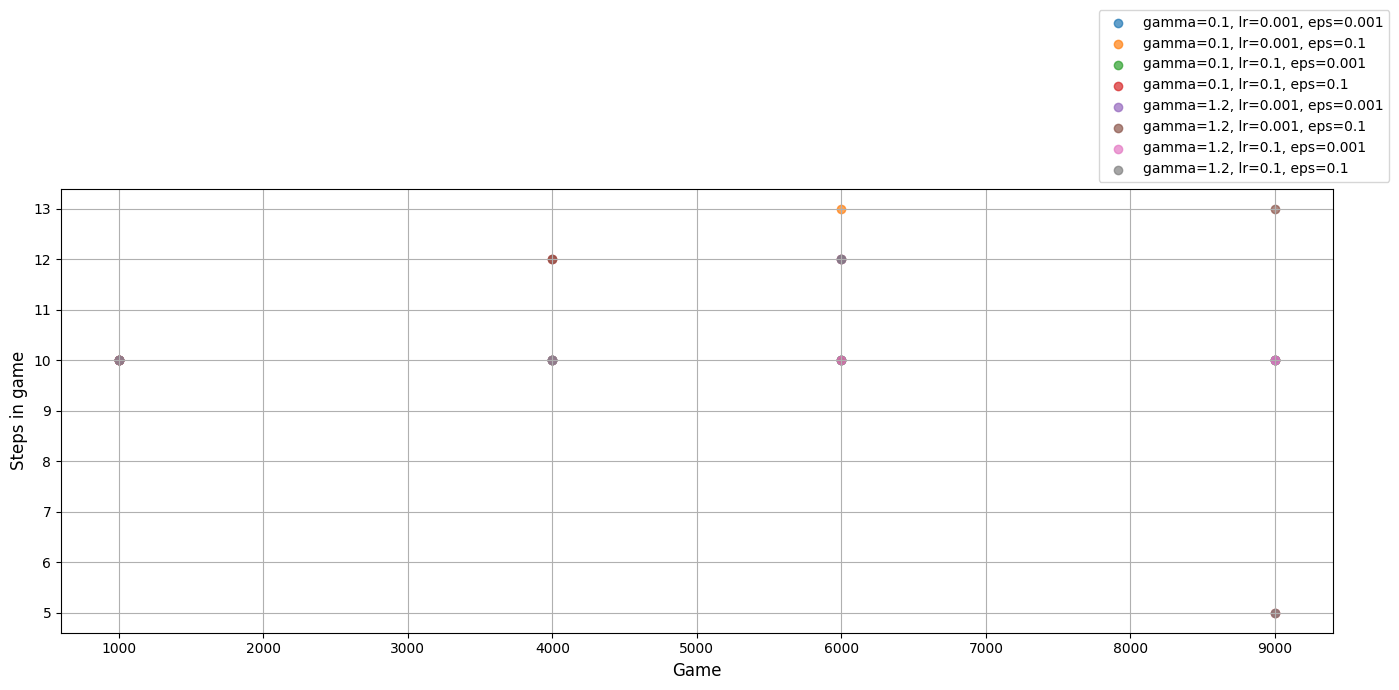

In [44]:
plt.figure(figsize=(14, 7))

for id, row in results.iterrows():
    label = f'gamma={round(row["gamma"], 3)}, lr={round(row["lr"], 3)}, eps={round(row["eps"], 3)}'

    data = [
        row['steps_per_game'][1000],
        row['steps_per_game'][4000],
        row['steps_per_game'][6000],
        row['steps_per_game'][9000],
    ]
    x = [1000, 4000, 6000, 9000]
    plt.scatter(x, data, linestyle='-', label=label, alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right')
plt.grid(True, linestyle='-')
plt.xlabel('Game', fontsize=12)
plt.ylabel('Steps in game', fontsize=12)
plt.tight_layout()

# Другие стратегии выбора действий

In [79]:
Q_optimistic = np.ones((env.observation_space.n, env.action_space.n)) * 10
Q_default = np.zeros((env.observation_space.n, env.action_space.n))

In [80]:
def eps_choose_action(state):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n)
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def softmax_choose_action(state, Q, temperature=0.1):
  q_values = Q[state, :]

  exp_logits = np.exp(q_values / temperature)
  probabilities = exp_logits / np.sum(exp_logits, axis=0)

  action = np.random.choice(len(q_values), p=probabilities)
  return action

def ucb_choose_action(state, Q, N, total_counts, c=2):
    n_actions = Q.shape[1]

    # Если какое-то действие ещё не опробовано в этом состоянии — выбираем его
    if total_counts[state] == 0:
      return np.random.randint(0, env.action_space.n)

    ucb_values = Q[state] + c * np.sqrt(np.log(total_counts[state]) / (N[state]  + 1e-8))

    return np.argmax(ucb_values)

In [81]:
class RLAgentEstimator(BaseEstimator):
    def __init__(
        self,
        optimistic=False,
        strategy='eps',
        gamma=gamma,
        learning_rate=lr_rate,
        eps=epsilon
    ):
        if strategy not in ['eps', 'ucb', 'softmax']:
          raise ValueError('Unknown strategy')

        self.gamma = gamma
        self.learning_rate = lr_rate
        self.eps = eps
        self.optimistic=optimistic
        self.strategy = strategy

    def learn(self, state, state2, reward, action, done):
      if done:
        self.Q[state, action] = Q[state, action] + self.learning_rate * (reward - Q[state, action])
      else:
        self.Q[state, action] = Q[state, action] + self.learning_rate * (reward + self.gamma * np.max(Q[state2, :]) - Q[state, action])

    def evaluate_game(self):
      wins_arr = []
      min_game = 0
      total_games = 10000
      max_steps = 100

      self.Q = np.copy(Q_optimistic) if self.optimistic else np.copy(Q_default)

      total_count = np.zeros(env.observation_space.n) # UCB only
      N = np.zeros(self.Q.shape) # UCB only

      cumulative_rewards = np.zeros((total_games, max_steps))
      steps_per_game = np.zeros(total_games)

      for game in tqdm(range(total_games)):
        state = env.reset()
        t = 0

        while t < max_steps:
            # Проверяем последние 5 игр
            if (len(wins_arr) >= 5 and wins_arr[-5:] == [1, 1, 1, 1, 1] and min_game == 0):
                min_game = game

            t += 1

            if self.strategy == 'ucb':
              action = ucb_choose_action(state, self.Q, N, total_count)
              N[state, action] += 1
              total_count[state] += 1
            elif self.strategy == 'softmax':
              action = softmax_choose_action(state, self.Q)
            else:
              action = eps_choose_action(state)

            state2, reward, done, info = env.step(action)

            if (t == 1):
              cumulative_rewards[game, t - 1] = reward
            else:
              cumulative_rewards[game, t - 1] = cumulative_rewards[game, t - 2] + reward

            if t == max_steps:
              done = True

            self.learn(state, state2, reward, action, done)

            state = state2

            if done:
              # Если эпизод завершился победой
              if reward == 1:
                wins_arr.append(1)
              # Если эпизод завершился не победой
              else:
                wins_arr.append(0)
              break

        steps_per_game[game] = t

      mean_cum_rewards = np.mean(cumulative_rewards, axis=0)
      return np.sum(wins_arr), min_game, mean_cum_rewards, steps_per_game

    def score(self):
        return self.evaluate_game()

In [82]:
base_agent = RLAgentEstimator()
base_score = base_agent.score()

100%|██████████| 10000/10000 [00:08<00:00, 1160.88it/s]


In [83]:
optimistic_agent = RLAgentEstimator(optimistic=True)
optimistic_score = optimistic_agent.score()

100%|██████████| 10000/10000 [00:08<00:00, 1216.36it/s]


In [84]:
softmax_agent = RLAgentEstimator(strategy='softmax')
softmax_score = softmax_agent.score()

100%|██████████| 10000/10000 [00:11<00:00, 843.71it/s]


In [85]:
ucb_agent = RLAgentEstimator(strategy='ucb')
ucb_score = ucb_agent.score()

100%|██████████| 10000/10000 [00:07<00:00, 1371.21it/s]


## Количество побед

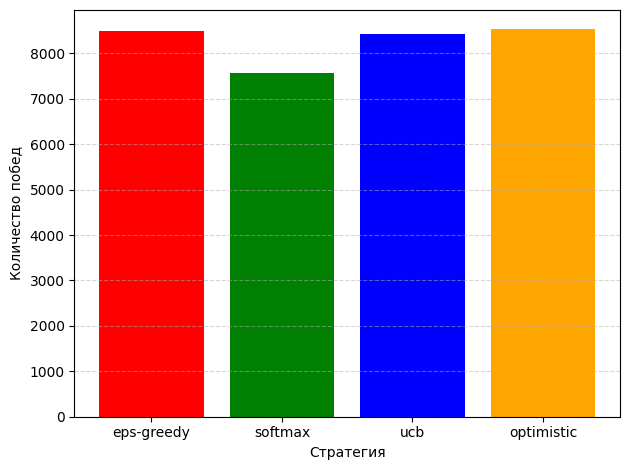

In [98]:
strategies = ['eps-greedy', 'softmax', 'ucb', 'optimistic']
wins = [
    base_score[0],
    softmax_score[0],
    ucb_score[0],
    optimistic_score[0]
]

plt.bar(strategies, wins, color=['red', 'green', 'blue', 'orange'])

plt.xlabel('Стратегия')
plt.ylabel('Количество побед')

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

## Первые 5 побед

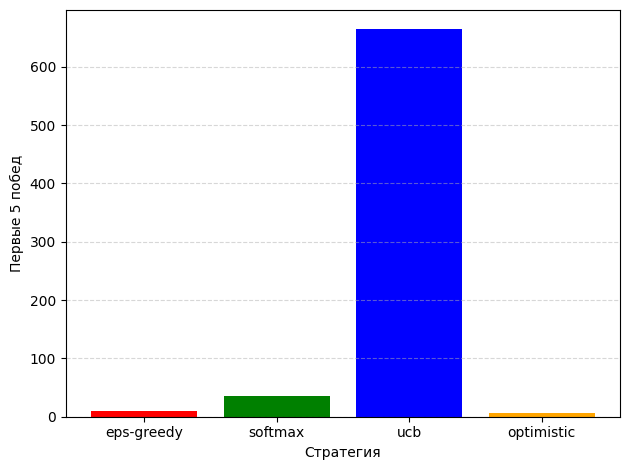

In [97]:
strategies = ['eps-greedy', 'softmax', 'ucb', 'optimistic']
wins = [
    base_score[1],
    softmax_score[1],
    ucb_score[1],
    optimistic_score[1]
]

plt.bar(strategies, wins, color=['red', 'green', 'blue', 'orange'])

plt.xlabel('Стратегия')
plt.ylabel('Первые 5 побед')

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

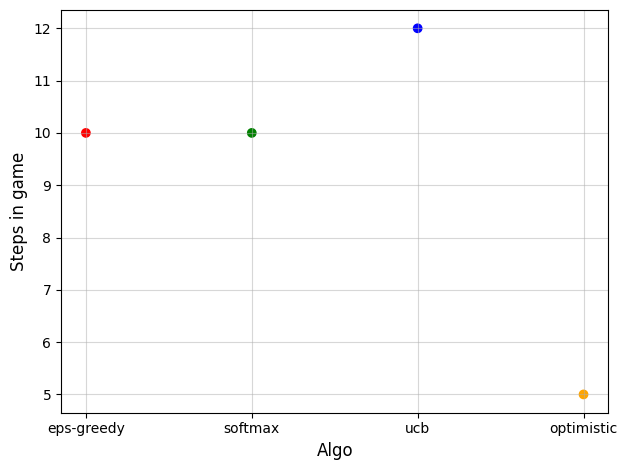

In [96]:
steps = [
    base_score[3][1000],
    softmax_score[3][1000],
    ucb_score[3][1000],
    optimistic_score[3][1000],
]
strategies = ['eps-greedy', 'softmax', 'ucb', 'optimistic']

plt.scatter(strategies, data, color=['red', 'green', 'blue', 'orange'])

plt.grid(True, linestyle='-', alpha=0.5)
plt.xlabel('Algo', fontsize=12)
plt.ylabel('Steps in game', fontsize=12)
plt.tight_layout()